In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
sns.set_style('whitegrid')
%matplotlib inline

# Dataset Load

In [5]:
df_train_path = os.path.join("train.csv")
df_test_path = os.path.join("test.csv")
df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)

# Exploratory analysis and data crunching

In [6]:
print(df_train.info())
print("//--------------//-----------//")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
//--------------//-----------//
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null obj

In [7]:
# Let's make the passengerID the index of df just for organization issues....
df_train.set_index('PassengerId', inplace=True)
df_test.set_index('PassengerId', inplace=True)

In [8]:
# Cabin have a lot of nulls, so it's very likely to have no impact on the model. Let's drop it from test and train df's
df_train.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

In [9]:
# Ticket is an ID of the passage.
# Since socio-economic can be inferred by Pclass, Fare and other fields, let's just ignore this field.
df_train.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

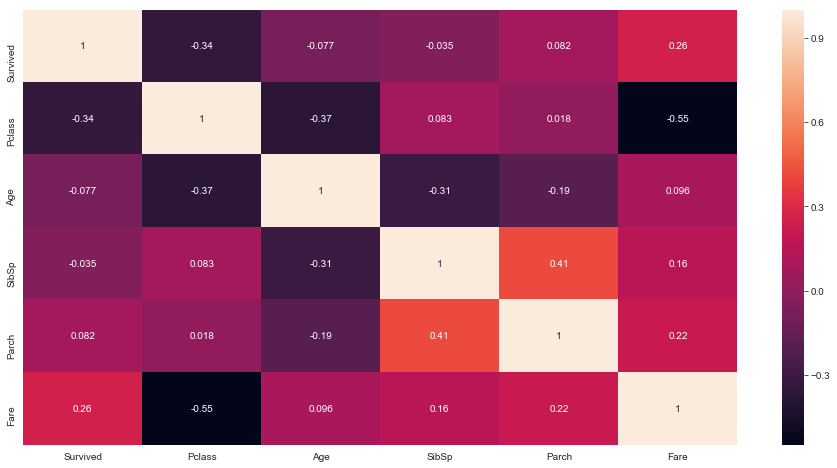

In [10]:
# Let's evaluate the df we have now.
plt.figure(figsize=(16,8))
sns.heatmap(df_train.corr(), annot=True)

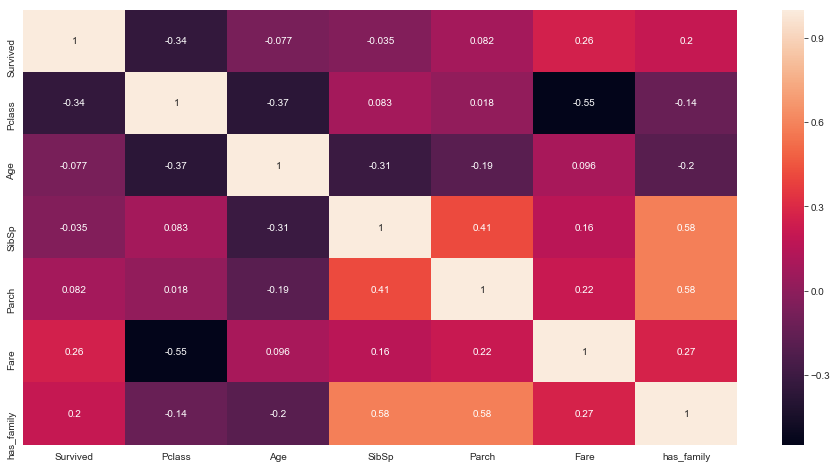

In [11]:
# SibSp and Parch have very little impact, let's try to make it more meaningful
df_train['has_family'] = 0
df_test['has_family'] = 0

for index, row in df_train[(df_train['SibSp'] > 0) | (df_train['Parch'] > 0)].iterrows():
    df_train.loc[index, 'has_family'] = 1

for index, row in df_test[(df_test['SibSp'] > 0) | (df_test['Parch'] > 0)].iterrows():
    df_test.loc[index, 'has_family'] = 1
    
#Let's see if our effort had results
plt.figure(figsize=(16,8))
sns.heatmap(df_train.corr(), annot=True)

In [12]:
# Has family has 0.2 corr with survived a lot more comparing sibsp and parch.
# It makes sense, who had family onboard have better chances of survivability.
# Now, let's remove Parch and sibsp from our df's
df_train.drop(['SibSp', 'Parch'], axis=1, inplace=True)
df_test.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [13]:
# Let's see our dataframes...
print(df_train.info())
print("//--------------//-----------//")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           714 non-null float64
Fare          891 non-null float64
Embarked      889 non-null object
has_family    891 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 102.6+ KB
None
//--------------//-----------//
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
Pclass        418 non-null int64
Name          418 non-null object
Sex           418 non-null object
Age           332 non-null float64
Fare          417 non-null float64
Embarked      418 non-null object
has_family    418 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 46.1+ KB
None


count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


(array([22., 19., 10., 11., 10., 10.,  8.,  4., 15., 25., 20., 71., 24.,
        85., 74., 35., 61., 35., 72., 47., 25., 41., 33., 23., 39., 14.,
        27., 10., 29., 28.,  9., 23.,  6., 14., 13.,  5.,  9.,  8., 10.,
         9.,  3.,  2.,  0.,  2.,  3.,  0.,  1.,  1.,  0.,  1.]),
 array([ 0.17  ,  1.7666,  3.3632,  4.9598,  6.5564,  8.153 ,  9.7496,
        11.3462, 12.9428, 14.5394, 16.136 , 17.7326, 19.3292, 20.9258,
        22.5224, 24.119 , 25.7156, 27.3122, 28.9088, 30.5054, 32.102 ,
        33.6986, 35.2952, 36.8918, 38.4884, 40.085 , 41.6816, 43.2782,
        44.8748, 46.4714, 48.068 , 49.6646, 51.2612, 52.8578, 54.4544,
        56.051 , 57.6476, 59.2442, 60.8408, 62.4374, 64.034 , 65.6306,
        67.2272, 68.8238, 70.4204, 72.017 , 73.6136, 75.2102, 76.8068,
        78.4034, 80.    ]),
 <a list of 50 Patch objects>)

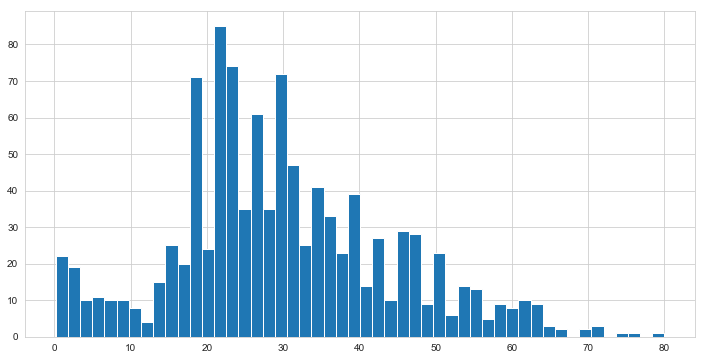

In [14]:
# Evaluating metrics to decide which metric to fill na's
# Let's make it concatenating both dataframes to have a greater sample
plt.figure(figsize=(12,6))
print(pd.concat([df_train, df_test])['Age'].describe())
plt.hist(pd.concat([df_train, df_test])[pd.isna(pd.concat([df_train, df_test])['Age']) == False]['Age'], bins=50)

In [15]:
# Age has some missing values both in train and test df.
# let's fill with mean + a random value in the interval -std,+std
df_train['Age'].fillna(
    pd.concat([df_train, df_test])['Age'].mean() 
    + np.random.randint(low=-pd.concat([df_train, df_test])['Age'].std(),
                        high=pd.concat([df_train, df_test])['Age'].std()), inplace=True)
df_test['Age'].fillna(
    pd.concat([df_train, df_test])['Age'].mean()
    + np.random.randint(low=-pd.concat([df_train, df_test])['Age'].std(), 
                        high=pd.concat([df_train, df_test])['Age'].std()), inplace=True)

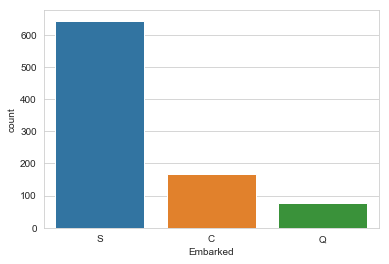

In [16]:
# We also have 2 missing values in Embarked.
# Let's see which is the most common embarked value.
sns.countplot(x='Embarked', data=df_train)

# The most common is 'S', then let's make it our value.
df_train['Embarked'].fillna('S', inplace=True)

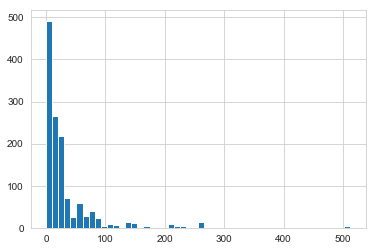

In [17]:
# one fare in testvalue is missing.
# Let's see the distribution to decide which metric we will use
concat_df = pd.concat([df_train, df_test])
plt.hist(concat_df[pd.isna(concat_df['Fare']) == False]['Fare'], bins=50)
concat_df['Fare'].describe()
df_test.fillna(concat_df['Fare'].mean(), inplace=True)

In [18]:
#Converting values to integers.
df_train['Fare'] = df_train['Fare'].astype(int)
df_test['Fare'] = df_test['Fare'].astype(int)

df_train['Age'] = df_train['Age'].astype(int)
df_test['Age'] = df_test['Age'].astype(int)

In [19]:
df_train[df_train.index==760]

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,has_family
PassengerId,,,,,,,,
760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33,86,S,0


In [20]:
def extract_title(complete_name):
    regex = re.compile('[A-Za-z]*, ([A-Za-z ]*). ')
    res = regex.search(complete_name)
    return res.group(1)

In [21]:
# Drop the name column since probably doesn't impact on survivability
df_train['Title'] = df_train['Name'].apply(extract_title)
df_test['Title'] = df_test['Name'].apply(extract_title)

** Evaluating Pclass **

In [22]:
# We know that Pclass has a great corr with survived.
# Let's get deep into it
prop_surv_cl1 = (df_train[(df_train['Survived'] == 1) & (df_train['Pclass'] == 1)].shape[0] / df_train[df_train['Pclass'] == 1].shape[0])
prop_surv_cl2 = (df_train[(df_train['Survived'] == 1) & (df_train['Pclass'] == 2)].shape[0] / df_train[df_train['Pclass'] == 2].shape[0])
prop_surv_cl3 = (df_train[(df_train['Survived'] == 1) & (df_train['Pclass'] == 3)].shape[0] / df_train[df_train['Pclass'] == 3].shape[0])

In [23]:
avg_surv_df = df_train[(df_train['Survived'] == 1)].shape[0] / df_train.shape[0]

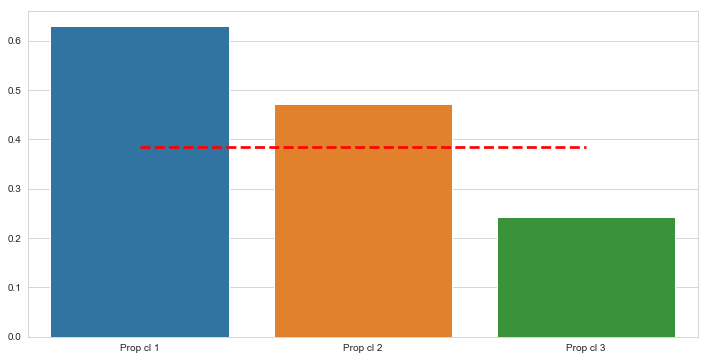

In [24]:
plt.figure(figsize=(12,6))
X=['Prop cl 1','Prop cl 2','Prop cl 3']
arr = [prop_surv_cl1, prop_surv_cl2, prop_surv_cl3]
sns.barplot(y=arr, x=X)
sns.pointplot(y=[avg_surv_df, avg_surv_df, avg_surv_df], x=X, color='r', markers='', linestyles='--')
# We can see that this is going to be a decisive parameter in our classification

** Evaluating Age **

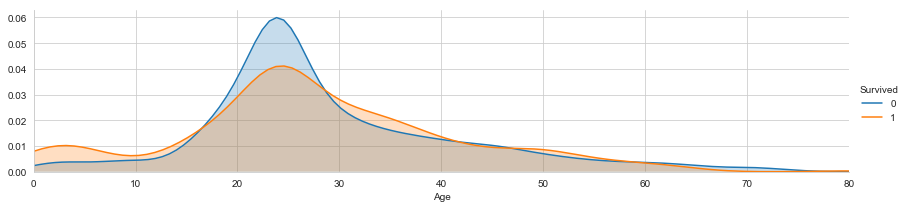

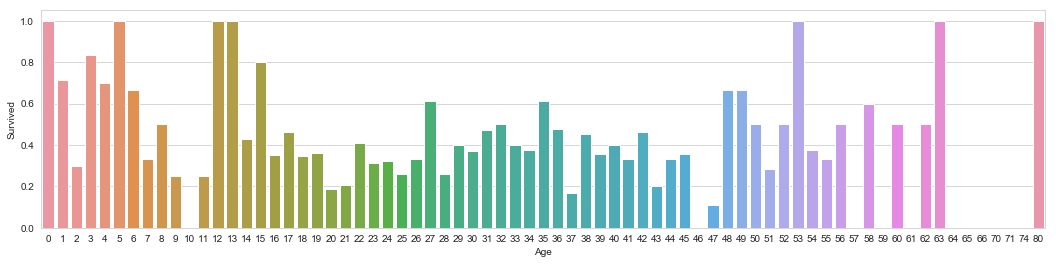

In [25]:
facet = sns.FacetGrid(df_train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade= True)
facet.set(xlim=(0, df_train['Age'].max()))
facet.add_legend()

fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = df_train[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

# There is a lot of people surviving under 16.
# Let's use this info in some way in the future.

** Evaluating Embarked **

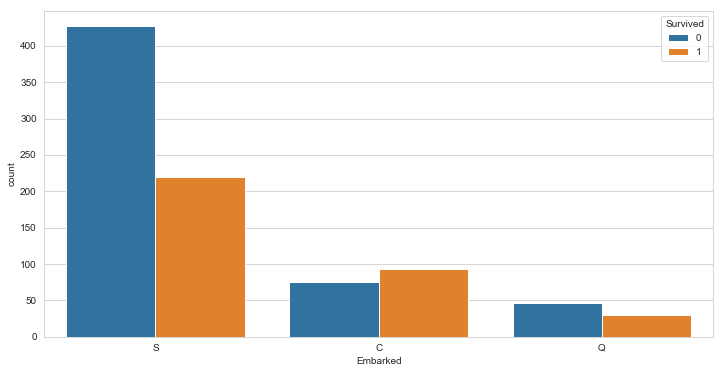

In [26]:
plt.figure(figsize=(12,6))
sns.countplot(x='Embarked', hue='Survived', data=df_train)
# It seems that this feature also impacts in survivability

** Title evaluatuion **

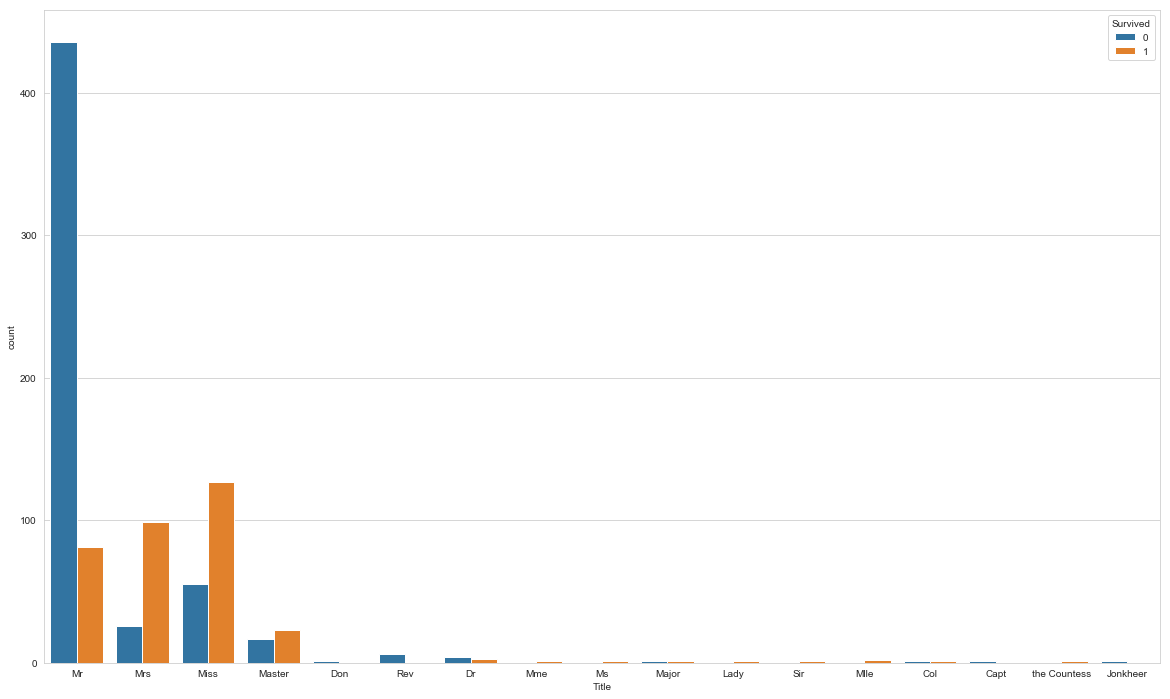

In [27]:
plt.figure(figsize=(20,12))
sns.countplot(x='Title', hue='Survived', data=df_train)

In [28]:
# Now we need to convert categorical fields...
# this is almost an one hot representation.

# First, let's put age in another form of representation
for index, row in df_train[df_train['Age'] <= 16].iterrows():
    df_train.loc[index, 'Sex'] = 'child'
    
for index, row in df_test[df_test['Age'] <= 16].iterrows():
    df_test.loc[index, 'Sex'] = 'child'

train_sex_dummies = pd.get_dummies(df_train['Sex'])
train_sex_dummies.columns = ['Child','Female','Male']
train_sex_dummies.drop(['Male'], axis=1, inplace=True)

test_sex_dummies = pd.get_dummies(df_test['Sex'])
test_sex_dummies.columns = ['Child','Female','Male']
test_sex_dummies.drop(['Male'], axis=1, inplace=True)

df_train.drop('Sex', axis=1, inplace=True)
df_test.drop('Sex', axis=1, inplace=True)

df_train = df_train.join(train_sex_dummies)
df_test = df_test.join(test_sex_dummies)

In [29]:
train_class_dummies = pd.get_dummies(df_train['Pclass'], drop_first=True)
test_class_dummies = pd.get_dummies(df_test['Pclass'], drop_first=True)

train_class_dummies.rename(index=int, columns={2:'Class_2', 3:'Class_3'}, inplace=True)
test_class_dummies.rename(index=int, columns={2:'Class_2', 3:'Class_3'}, inplace=True)

df_train = df_train.join(train_class_dummies)
df_test = df_test.join(test_class_dummies)

df_train.drop('Pclass', axis=1, inplace=True)
df_test.drop('Pclass', axis=1, inplace=True)

In [30]:
df_train.head()

,Survived,Name,Age,Fare,Embarked,has_family,Title,Child,Female,Class_2,Class_3
PassengerId,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22,7,S,1,Mr,0,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,71,C,1,Mrs,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26,7,S,0,Miss,0,1,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,53,S,1,Mrs,0,1,0,0
5,0,"Allen, Mr. William Henry",35,8,S,0,Mr,0,0,0,1


In [31]:
def fill_nonex_col(base, change):
    for val in base:
        if val not in change:
            change[val] = 0
    return change

In [32]:
train_title_dummies = pd.get_dummies(df_train['Title'], drop_first=True)
test_title_dummies = pd.get_dummies(df_test['Title'], drop_first=True)

In [33]:
train_title_dummies = fill_nonex_col(test_title_dummies, train_title_dummies)
test_title_dummies =  fill_nonex_col(train_title_dummies, test_title_dummies)

In [34]:
df_train = df_train.join(train_title_dummies)
df_test = df_test.join(test_title_dummies)

df_train.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)
df_train.drop('Title', axis=1, inplace=True)
df_test.drop('Title', axis=1, inplace=True)

In [35]:
train_emb_dummies = pd.get_dummies(df_train['Embarked'], drop_first=True)
test_emb_dummies = pd.get_dummies(df_test['Embarked'], drop_first=True)

train_emb_dummies.rename(index=int, columns={'Q':'Embarked_Q', 'S':'Embarked_S'}, inplace=True)
test_emb_dummies.rename(index=int, columns={'Q':'Embarked_Q', 'S':'Embarked_S'}, inplace=True)

df_train = df_train.join(train_emb_dummies)
df_test = df_test.join(test_emb_dummies)

df_train.drop('Embarked', axis=1, inplace=True)
df_test.drop('Embarked', axis=1, inplace=True)

In [36]:
df_train.head()

,Survived,Age,Fare,has_family,Child,Female,Class_2,Class_3,Col,Don,...,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess,Dona,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22,7,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1,38,71,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,26,7,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,35,53,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
5,0,35,8,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


In [37]:
df_test.head()

,Age,Fare,has_family,Child,Female,Class_2,Class_3,Dona,Dr,Master,...,Don,Jonkheer,Lady,Major,Mlle,Mme,Sir,the Countess,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,34,7,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
893,47,7,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
894,62,9,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
895,27,8,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
896,22,12,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Model Build

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('Survived', axis=1), df_train['Survived'], test_size=0.3)

NameError: name 'df_train' is not defined

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [632]:
batch_size = 100
num_classes = 2
epochs = 1000

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] criterion=gini, n_estimators=10 .................................
[CV]  criterion=gini, n_estimators=10, score=0.8076923076923077, total=   0.0s
[CV] criterion=gini, n_estimators=10 .................................
[CV]  criterion=gini, n_estimators=10, score=0.8173076923076923, total=   0.0s
[CV] criterion=gini, n_estimators=10 .................................
[CV]  criterion=gini, n_estimators=10, score=0.8115942028985508, total=   0.0s
[CV] criterion=gini, n_estimators=100 ................................
[CV]  criterion=gini, n_estimators=100, score=0.8221153846153846, total=   0.0s
[CV] criterion=gini, n_estimators=100 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, n_estimators=100, score=0.8557692307692307, total=   0.0s
[CV] criterion=gini, n_estimators=100 ................................
[CV]  criterion=gini, n_estimators=100, score=0.8164251207729468, total=   0.0s
[CV] criterion=gini, n_estimators=1000 ...............................
[CV] .. criterion=gini, n_estimators=1000, score=0.8125, total=   1.1s
[CV] criterion=gini, n_estimators=1000 ...............................
[CV]  criterion=gini, n_estimators=1000, score=0.8509615384615384, total=   1.2s
[CV] criterion=gini, n_estimators=1000 ...............................
[CV]  criterion=gini, n_estimators=1000, score=0.8067632850241546, total=   1.1s
[CV] criterion=gini, n_estimators=10000 ..............................
[CV] . criterion=gini, n_estimators=10000, score=0.8125, total=  12.3s
[CV] criterion=gini, n_estimators=10000 ..............................
[CV]  criterion=gini, n_estimators=10000, score=0.8461538461538461, total=  11.8s
[CV] criterion=gini, n_estim

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': (10, 100, 1000, 10000), 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [633]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.84      0.85      0.84       160
          1       0.77      0.76      0.77       108

avg / total       0.81      0.81      0.81       268



** Best Values: **
             precision    recall  f1-score   support

          0       0.81      0.87      0.84       164
          1       0.77      0.68      0.72       104

avg / total       0.80      0.80      0.80       268


In [634]:
pred = clf.predict(df_test)

In [635]:
df_test['Survived'] = pred

In [636]:
pred[0:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [637]:
with open('kggl_subm.csv', 'w') as file:
    file.write("PassengerId,Survived\n")
    for ind, row in df_test.iterrows():
        file.write(str(ind) + "," + str(row['Survived']) + '\n')